# The goal of this program is to create a live tracker of a hockey game.
## &emsp; Stats I would like to have live figures on are:
## &emsp;&emsp; Goals: 
### &emsp;&emsp;&emsp; [1] Graph of goals per team vs time-elapsed, w/ goal differential
### &emsp;&emsp;&emsp; [2] Table of goals per team per period, PPG's, SHG's

## &emsp; &emsp; Shots:
### &emsp;&emsp;&emsp; [1] Graph of shots per team vs time-elapsed, w/ shot differential
### &emsp;&emsp;&emsp; [2] Top 5 shooters for each team by: shots, missed shots, shot attempts, shooting%, +/-

##  &emsp;&emsp; Special Teams
### &emsp;&emsp;&emsp; [1] PIM per team, PP's per team, PPG's per team, PK's per team
### &emsp;&emsp;&emsp; [2] Table of penalties: Team, period, player, penalty, time


## Import necessary modules

In [1]:
from nhlstats import *
from nhlstats.formatters import csv
import pandas as pd, numpy as np
from datetime import *
from nhl import *
import ipywidgets as widgets
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import style, dates
import matplotlib.gridspec as gridspec
from datetime import time
import time
%matplotlib inline 

Hello world


In [3]:
today = date.today()

In [4]:
yesterday = today + timedelta(days=-1)

## Determine which game we want to look at

In [11]:
# Download data to pandas DF
games = pd.DataFrame(list_games(yesterday))
games = games.drop(columns=['season'])

#Create lists for all teams playing, and all game_id's
teams = []
game_ids = []
[teams.append(i) for i in games.away_team]
[teams.append(i) for i in games.home_team]
[game_ids.append(i) for i in games.game_id]

teams.sort()
def lst_unique(x):
    return list(dict.fromkeys(x))
teams = lst_unique(teams)

team_select = widgets.Dropdown(
    options=teams,
    value=teams[0],
    description='Team Name: ',
    disabled=False
)
display(games)

print("Which Team Are You Watching Today?")
display(team_select)

,away_score,away_team,date,game_id,game_state,home_score,home_team
0,2,Washington Capitals,2020-02-22,2019020948,Final,3,New Jersey Devils
1,2,Winnipeg Jets,2020-02-22,2019020949,Final,4,Philadelphia Flyers
2,5,Buffalo Sabres,2020-02-22,2019020950,Final,2,Pittsburgh Penguins
3,6,Carolina Hurricanes,2020-02-23,2019020951,Final,3,Toronto Maple Leafs
4,3,Montréal Canadiens,2020-02-23,2019020952,Final,0,Ottawa Senators
5,2,San Jose Sharks,2020-02-23,2019020953,Final,3,New York Rangers
6,3,Tampa Bay Lightning,2020-02-23,2019020955,Final,7,Arizona Coyotes
7,3,Columbus Blue Jackets,2020-02-23,2019020954,Final,4,Nashville Predators
8,3,Boston Bruins,2020-02-23,2019020956,Final,9,Vancouver Canucks
9,3,Florida Panthers,2020-02-23,2019020957,Final,5,Vegas Golden Knights


Which Team Are You Watching Today?


Dropdown(description='Team Name: ', options=('Anaheim Ducks', 'Arizona Coyotes', 'Boston Bruins', 'Buffalo Sab…

## Identify `game_id` based on drop down list value. Download `plays, shifts, shots` data into DF's

In [ ]:
game_id = 2019020958

In [12]:
team = team_select.value
game_id = games[(games.away_team == team) | (games.home_team == team)]['game_id'].min()

#Columns to keep in plays and shots DF's
keys = ['datetime','event_description','event_secondary_type','event_type','period','period_time','team_for']

plays = pd.DataFrame(list_plays(game_id))
plays = plays[keys]

shifts = pd.DataFrame(list_shifts(game_id))

shots = pd.DataFrame(list_shots(game_id))
shots = shots[keys]

# Identify away and home teams
#Away = games[games.game_id == game_id].away_team.max()
#Home = games[games.game_id == game_id].home_team.max()
Teams = shots.team_for.unique()
Away = Teams[0]
Home = Teams[1]

In [13]:
Home

'COL'

### Add column to `shots, plays` DF's for total game time elapsed

In [14]:
# Add column to shots Df for total time played
shots['Time'] = pd.to_datetime(shots.period_time, format="%M:%S")
plays['Time'] = pd.to_datetime(plays.period_time, format="%M:%S")

plays_1 = plays[plays.period == 1].reset_index()

plays_2 = plays[plays.period == 2].reset_index()
plays_2.Time += timedelta(minutes=20)

plays_3 = plays[plays.period == 3].reset_index()
plays_3.Time += timedelta(minutes=40)

#Parse out OT and Shootouts
plays_4 = plays[plays.period == 4].reset_index()
plays_4.Time += timedelta(minutes=60)

plays_5 = plays[plays.period == 5].reset_index()
plays_5.Time += timedelta(minutes=65)

plays = pd.concat([plays_1,plays_2,plays_3,plays_4,plays_5],axis=0)
plays.Time = [d.time() for d in plays.Time]

allP = plays['Time']
allP = pd.DataFrame(allP)
allP.set_index('Time',inplace=True)
allP.drop_duplicates(inplace=True)

plays.set_index('Time',inplace=True)

#### Create seperate DF's for Home and Away teams

In [15]:
away_plays = plays[plays.team_for == Away]
home_plays = plays[plays.team_for == Home]

## Create plots of goals per team vs time-elapsed & differential. Create table with goals per team per period, w/ PPGF, SHGF, ENG.

In [16]:
away_goals = away_plays[away_plays['event_type'] == 'GOAL'].reset_index()
home_goals = home_plays[home_plays['event_type'] == 'GOAL'].reset_index()

In [17]:
goals = 0
goalsAway = Away + " Total Goals"
for i in range(0,away_goals.shape[0]):
    goals +=1
    away_goals.loc[i, goalsAway] = int(goals)  

In [ ]:
goals = 0
goalsHome = Home + " Total Goals"
for i in range(0,home_goals.shape[0]):
    goals += 1
    home_goals.loc[i, goalsHome] = int(goals)

In [ ]:
away_goals.set_index('Time', inplace=True)
home_goals.set_index('Time', inplace=True)

In [18]:
away_goals = pd.DataFrame(away_goals[goalsAway])
home_goals = pd.DataFrame(home_goals[goalsHome])

In [19]:
goals = away_goals.join(home_goals)
goals

,LAK Total Goals,COL Total Goals
Time,,
00:04:47,1.0,NaN


In [20]:
goals = pd.concat([allP,away_goals,home_goals],axis=1,sort=True)
goals.fillna("N",inplace=True)

In [21]:
for i in range(0,goals.shape[0]):
    #Handle when one column starts with NaN
    if i == 0:
        if goals.iloc[0,0] == 'N':
            goals.iloc[0,0] = 0
            
        if goals.iloc[0,1] == 'N':
            goals.iloc[0,1] = 0
    
    #Remove other NaN values
    if goals.iloc[i,0] == 'N':
        goals.iloc[i,0] = goals.iloc[i-1,0]
        
    if goals.iloc[i,1] == 'N':
        goals.iloc[i,1] = goals.iloc[i-1,1]

## Shots:
### &emsp; [1] Graph of shots per team vs time-elapsed, w/ shot differential
### &emsp; [2] Top 5 shooters for each team by: shots, missed shots, shot attempts, shooting%, +/-

In [23]:
away_shots = away_plays[(away_plays['event_type'] == 'SHOT') | (away_plays['event_type'] == 'GOAL')].reset_index()
home_shots = home_plays[(home_plays['event_type'] == 'SHOT') | (home_plays['event_type'] == 'GOAL')].reset_index()

In [24]:
shots = 0
strNameA = Away + " Shot Total"
for i in range(0,away_shots.shape[0]):
    shots += 1
    away_shots.loc[i, strNameA] = int(shots)

In [25]:
shots = 0
strNameH = Home + " Shot Total"
for i in range(0,home_shots.shape[0]):
    shots+=1
    home_shots.loc[i, strNameH] = int(shots)

In [26]:
away_shots.set_index('Time', inplace=True)
home_shots.set_index('Time', inplace=True)

away_shots = pd.DataFrame(away_shots[strNameA])
home_shots = pd.DataFrame(home_shots[strNameH])

In [27]:
shots = allP.join(away_shots)
shots = shots.join(home_shots)

In [28]:
shots = allP.join(away_shots)
shots = shots.join(home_shots)

shots.fillna("N",inplace=True)

In [29]:
for i in range(0,shots.shape[0]):
    #Handle when one column starts with NaN
    if i == 0:
        if shots.iloc[0,0] == 'N':
            shots.iloc[0,0] = 0
            
        if shots.iloc[0,1] == 'N':
            shots.iloc[0,1] = 0
    
    #Remove other NaN values
    if shots.iloc[i,0] == 'N':
        shots.iloc[i,0] = shots.iloc[i-1,0]
        
    if shots.iloc[i,1] == 'N':
        shots.iloc[i,1] = shots.iloc[i-1,1]

shots['Differential'] = abs(shots[strNameA] - shots[strNameH])

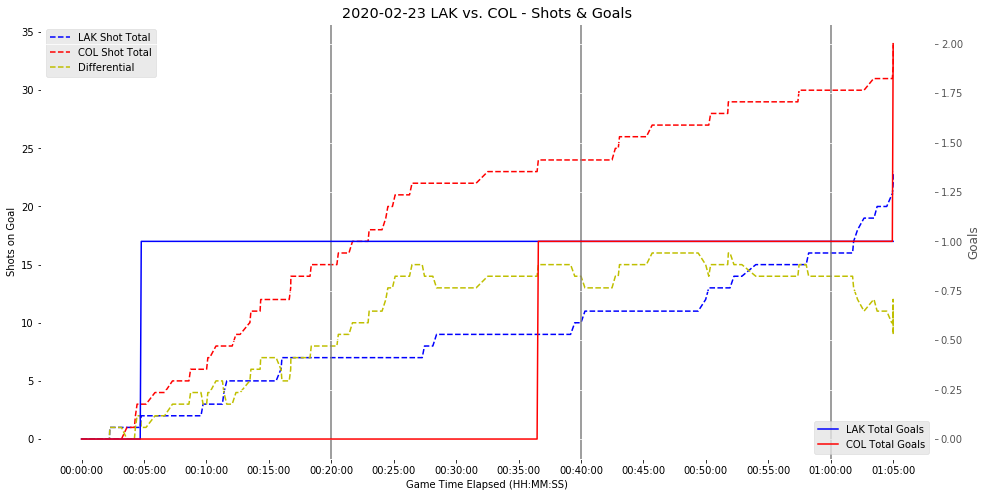

In [30]:
fig = plt.figure(figsize=(16,8))
ax0 = plt.subplot(1,1,1)

style.use('ggplot')

plt.plot(shots.index,shots.iloc[:,0],c='b',linestyle='--',label=shots.columns[0])
plt.plot(shots.index,shots.iloc[:,1],c='r',linestyle='--',label=shots.columns[1])
plt.plot(shots.index,shots.iloc[:,2],c='y',linestyle='--',label=shots.columns[2])
plt.xlabel('Game Time Elapsed (HH:MM:SS)')
plt.ylabel('Shots on Goal')
plt.legend(loc=2)

#Add vertical bars to graph to mark end of periods.
plt.axvline(x=1200,c='grey')
plt.axvline(x=2400,c='grey')
plt.axvline(x=3600,c='grey')

#Add goals to right side axis
ax1 = ax0.twinx()

plt.plot(goals.index,goals.iloc[:,0],c='b',label=goals.columns[0])
plt.plot(goals.index,goals.iloc[:,1],c='r',label=goals.columns[1])
plt.ylabel('Goals')

#Define formatting function for x axis
formatter = mpl.ticker.FuncFormatter(lambda ms, x: time.strftime('%H:%M:%S', time.gmtime(ms)))
ax1.xaxis.set_major_formatter(formatter)

x = [i * 60 for i in range(0,70,5)]
ax1.set_xticks(x)

plt.legend(loc=4)

plt.title(f"{today} {Away} vs. {Home} - Shots & Goals")
plt.show()

In [ ]:
shots.join(goals)[145:200]

In [ ]:
#for game in list_games():  # No args will list all games today
#    game_id = game['game_id']
#    plays = list_plays(game_id)  # get plays, normalized
#    
#    with open('{}.csv'.format(game_id), 'w') as f:
#        csv.dump(plays, f)

In [ ]:
#gameid = "2019020418"
#
#plays = pd.DataFrame(list_plays(gameid))
#shifts = pd.DataFrame(list_shifts(gameid))

#plays.head()
#shifts.head()

In [ ]:
#df = pd.DataFrame(list_plays(gameid))
#df.head(30)

In [2]:
@widgets.interact_manual(
    color=['blue', 'red', 'green'], lw=(1., 10.))
def plot(freq=1., color='blue', lw=2, grid=True):
    t = np.linspace(-1., +1., 1000)
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(t, np.sin(2 * np.pi * freq * t),
            lw=lw, color=color)
    ax.grid(grid)

interactive(children=(FloatSlider(value=1.0, description='freq', max=3.0, min=-1.0), Dropdown(description='col…